# HackerNews data analysis challenge with Spark

In this notebook, you will analyse a dataset of (almost) all submitted HackerNews posts with Spark. 

The notebook is a convenient way to explore your data, but you will be asked to implement corresponding functions in the `spark_rdd.py` file that will be submitted to KATE. Having standalone functions is a good way to automate reporting of the different metrics we will look at in a prouction environment.

Let's start by importing some of the libraries you will need.

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
from pyspark import SparkContext
import spark_rdd as sp

sc = SparkContext.getOrCreate()
print(sc)
print("Ready to go!")
%matplotlib inline

<SparkContext master=local[*] appName=pyspark-shell>
Ready to go!


The file has one JSON entry per line. In order to make accessing it easier, first turn each entry as a dictionary and use `persist()` to cache the resulting RDD. 

Remember to download the dataset (instructions in `Readme.md`)

In [2]:
dataset_json = sc.textFile("data/HNStories.json")
dataset = dataset_json.map(lambda x: json.loads(x))
dataset.persist()

PythonRDD[2] at RDD at PythonRDD.scala:53

Finally, Spark has many helper functions on top of the ones we have studied which you will find useful. You can view them at [http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD)

### Function `count_elements_in_dataset`

Lets start with some initial analysis. 

**How many elements are in your datasets?**


In [3]:
%%time
sp.count_elements_in_dataset(dataset)

CPU times: user 10.8 ms, sys: 5.26 ms, total: 16 ms
Wall time: 6.6 s


1333789

### Function `get_first_element`

**What does the first element look like? Assign the result to a variable called `first` **


In [3]:
sp.get_first_element(dataset)

{'author': 'TuxLyn',
 'created_at': '2014-05-29T08:25:40Z',
 'created_at_i': 1401351940,
 'num_comments': 0,
 'objectID': '7815290',
 'points': 1,
 'title': 'DuckDuckGo Settings',
 'url': 'https://duckduckgo.com/settings'}

### Function `get_all_attributes`

Each element is a dictionary of attributes and their values for a post. 
**Can you find the set of all attributes used throughout the RDD?**
The function `dictionary.keys()` gives you the list of attributes of a dictionary.

In [5]:
attributes = []
# count = dataset.count()
for line in dataset.take(5000): # HOW DO I GET ALL ATTRIBUTES?
    for key in line.keys():
        if key not in attributes:
            attributes.append(key)
print(attributes)

['author', 'created_at', 'created_at_i', 'num_comments', 'objectID', 'points', 'title', 'url', 'story_text']


### Function `get_elements_w_same_attributes`

We see that there are more attributes than just the one used in the first element. Can you filter the dataset to keep only elements that have the same set of attributes as the first element?
Hint: you might want to write a function that compares attributes for two elements and apply it on your dataset.

In [3]:
sp.get_elements_w_same_attributes(dataset).count()

1145245

How many elements did you find?

### How many posts through time

The field `created_at_i` is very useful, it gives you a UNIX timestamp of the time at which the file was created. The following function lets you extract a time from a timestamp.

In [3]:
def extract_time(timestamp):
    return dt.utcfromtimestamp(timestamp)

### Function `get_min_max_timestamps`

**Find the minimum and maximum timestamps in the RDD and call them `min_time` and `max_time`.** 
These correspond to the first and last post, when did they occur? For the function `get_min_max_timestamps` you need to return min_time and max_time given a dataset

In [5]:
times = sp.get_min_max_timestamps(dataset)

In [6]:
# Find the minimum timestamp
min_time = times[0]
min_time

datetime.datetime(2006, 10, 9, 18, 21, 51)

In [7]:
# Find the max timestamp
max_time = times[1]
max_time

datetime.datetime(2014, 5, 29, 8, 25, 40)

In [99]:
delta = (max_time - min_time)/200
delta

datetime.timedelta(days=13, seconds=81469, microseconds=145000)

### Function `get_number_of_posts_per_bucket`

Now lets analyse how many elements through time. The following function assigns a record to one of 200 "buckets" of time. **Use it to count the number of elements that fall within each bucket and call the result `bucket_rdd`.** The result should be such that `buckets` below generates the corresponding output. If you want to use this function in your `spark_rdd.py` you will need to redefine it in the file.

In [16]:
def get_bucket(rec, min_timestamp, max_timestamp):
    interval = (max_timestamp - min_timestamp + 1) / 200.0
    return int((rec['created_at_i'] - min_timestamp)/interval)

In [21]:
test = sp.get_number_of_posts_per_bucket(dataset, min_time, max_time)

We can then use this to plot the number of submitted posts over time.

In [22]:
bs = [dt.utcfromtimestamp(x[0]*interval + min_time) for x in buckets]
ts = [x[1] for x in buckets]
plt.plot(bs, ts)

TypeError: 'PipelinedRDD' object is not iterable

### Function `get_number_of_posts_per_hour`

The following function gets the hour of the day at which a post was submitted. **Use it to find the number of posts submitted at each hour of the day.** The value of `hours_buckets` should match the one printed below.

In [23]:
def get_hour(rec):
    t = dt.utcfromtimestamp(rec['created_at_i'])
    return t.hour

In [6]:
hours_buckets_rdd = sp.get_number_of_posts_per_hour(dataset)

In [7]:
hours_buckets = sorted(hours_buckets_rdd.collect())

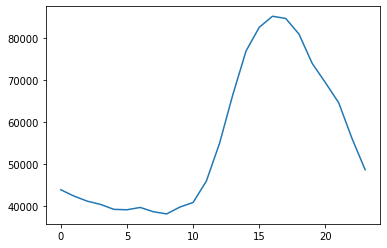

In [8]:
hrs = [x[0] for x in hours_buckets]
sz = [x[1] for x in hours_buckets]
plt.plot(hrs, sz)

### Function `get_score_per_hour`

The number of points scored by a post is under the attribute `points`. **Use it to compute the average score received by submissions for each hour.**

In [141]:
points_hour = dataset.map(lambda line: (dt.utcfromtimestamp(line['created_at_i']).hour, (line['points'], 1)))
points_hour.reduceByKey(lambda t1, t2: (t1[0] + t2[0], t1[1] + t2[1]) ).map(lambda pair: (pair[0], pair[1][0]/pair[1][1]))

[(8, (1, 1)), (8, (1, 1))]

In [9]:
scores_per_hour_rdd = sp.get_score_per_hour(dataset)

In [10]:
scores_per_hour = sorted(scores_per_hour_rdd.collect())

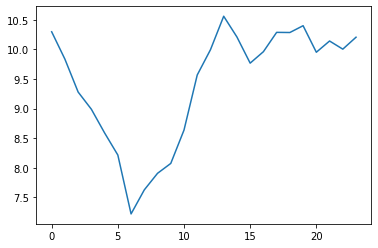

In [12]:
hrs = [x[0] for x in scores_per_hour]
sz = [x[1] for x in scores_per_hour]
plt.plot(hrs, sz);

### Function `get_proportion_of_scores`

It may be more useful to look at sucessful posts that get over 200 points. **Find the proportion of posts that get above 200 points per hour.**

In [11]:
def get_points(line):
    if line['points'] >= 200:
        return 1
    return 0 

In [13]:
points_hour = dataset.map(lambda line: (dt.utcfromtimestamp(line['created_at_i']).hour, (get_points(line), 1)))
points_hour.reduceByKey(lambda t1, t2: (t1[0] + t2[0], t1[1] + t2[1]) ).map(lambda pair: (pair[0], pair[1][0]/pair[1][1])).take(5)

[(0, 0.007792030256772459),
 (13, 0.009050181905649598),
 (1, 0.0064648561923412685),
 (14, 0.008241579679436348),
 (2, 0.0064843598212551)]

In [3]:
prop_per_hour_rdd = sp.get_proportion_of_scores(dataset)

In [5]:
prop_per_hour = sorted(prop_per_hour_rdd.collect())

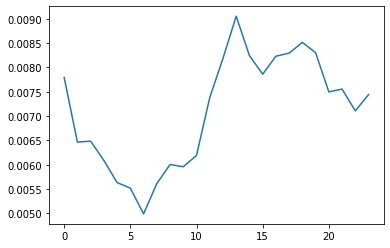

In [7]:
hrs = [x[0] for x in prop_per_hour]
sz = [x[1] for x in prop_per_hour]
plt.plot(hrs, sz);

### Function `get_proportion_of_success`

The following function lists the word in the title. **Use it to count the number of words in the title of each post, and look at the proportion of successful posts for each title length.**

If an element does not have a title, it should count it as a length of 0.

In [11]:
import re
def get_words(line):
    if 'title' in line:
        return len(re.compile("\w+").findall(line['title']))
    return 0

In [7]:
prop_per_title_length_rdd = sp.get_proportion_of_success(dataset)

In [8]:
prop_per_title_length = sorted(prop_per_title_length_rdd.collect())

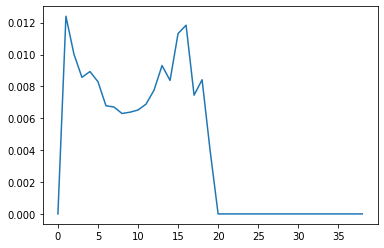

In [9]:
hrs = [x[0] for x in prop_per_title_length]
sz = [x[1] for x in prop_per_title_length]
plt.plot(hrs, sz)

### Function `get_title_length_distribution`

Lets compare this with the distribution of number of words. **Count for each title length the number of submissions with that length.**

In [15]:
test = dataset.map(lambda line: (get_words(line), 1)).reduceByKey(lambda l1, l2: l1+l2)
test.take(5)

[(13, 40283), (0, 6328), (26, 11), (1, 11209), (14, 21734)]

In [3]:
submissions_per_length_rdd = sp.get_title_length_distribution(dataset)

In [4]:
submissions_per_length = sorted(submissions_per_length_rdd.collect())

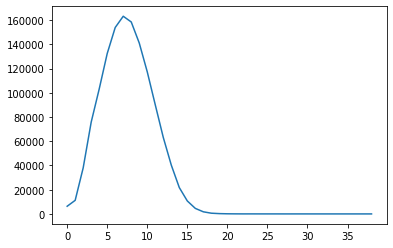

In [5]:
hrs = [x[0] for x in submissions_per_length]
sz = [x[1] for x in submissions_per_length]
plt.plot(hrs, sz)

Looks like most people are getting it wrong!

### Optional

For this task, you will need a new function: `takeOrdered()`. Like `take()` it collects elements from an RDD. However, it can be applied to take the smallest elements. For example, `takeOrdered(10)` returns the 10 smallest elements. Furthermore, you can pass it a function to specify the way in which the elements should be ordered. For example, `takeOrdered(10, lambda x: -x)` will return the 10 largest elements.

The function below extracts the url domain out of a record. **Use it to count the number of distinct domains posted to.**

In [ ]:
from urllib.parse import urlparse
def get_domain(rec):
    url = urlparse(rec['url']).netloc
    if url[0:4] == 'www.':
        return url[4:]
    else:
        return url
print(get_domain(dataset.take(1)[0]))

In [ ]:
# Count the number of distinct domains


Using `takeOrdered()` find the 25 most popular domains posted to.

In [ ]:
print(top25)

In [ ]:
index = np.arange(25)
labels = [x[0] for x in top25]
counts = np.array([x[1] for x in top25]) * 100.0/dataset.count()
plt.xticks(index,labels, rotation='vertical')
plt.bar(index, counts, 0.5)